# Etude de la détection automatique de caractéristiques sur un signal audio
![ISEN Lille](src/isen.jpg)



Référents :
* A. Frappé 
* A. Gonzalez
* B. Larras

Projet M1 réalisé par :
* J. Le Bellego
* S. Lecoq

# Mise en place

Ce notebook [Jupyter](http://jupyter.org/) se compose de deux types de cellules :

- Celles contenant du **code Python** peuvent être exécuté en appuyant sur simultanément sur les touches *Maj + Entrée*.  
- Celles contenant du **rendu** ou du **markdown** n'ont aucun effet particulier en dehors de contenir du texte.

Le code est prévu pour être exécuté au moins une fois dans l'ordre afin de pouvoir définir tous les éléments, après quoi il vous est possible d'éditer et d'exécutez une celulle en particulier. Toutefois, il est recommandé d'utiliser le fichier **Tests** pour faciliter les tests.

### Initialisation et dépendances 
Etape intermédiaire consistant à importer les bibliothèques et à configurer le Notebook.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%run -i bin/imports.py

In [2]:
%%html
<script>
IPython.OutputArea.prototype._should_scroll = lines => { return false }  
</script>
<style>
.output_wrapper button.btn.btn-default, .output_wrapper .ui-dialog-titlebar { display: none; }
.ui-resizable { pointer-events:none; }
</style>

# Propriétés du fichier audio

La source du fichier audio qui sera utilisée par la démo peut être configurée dans la cellule ci-dessous.

In [3]:
# Source
file = "src/test2.wav"

Ci-dessous sont définit automatiquement les paramètres du fichier source :
* **y** : Signal d'entrée
* **fs** : Fréquence d'échantillonage de ce signal
* **N** : Nombre de points échantillonés
* **t** : Points temporels

In [4]:
# Lecture du fichier audio
fs, y = sw.read(file)
# Nombre d'échantillons et échelle temporelle
N = len(y)
t = np.linspace(0, N/fs, N)

### Spectre d'amplitude

Il représente l'amplitude relative des impulsions sonores (en ordonnée) selon le temps (en abscisse).

Il est affiché par la fonction [**plot_specamp(y, t)**](https://github.com/lowlighter/sound/blob/master/bin/plot_specamp.py).

<IPython.core.display.Javascript object>


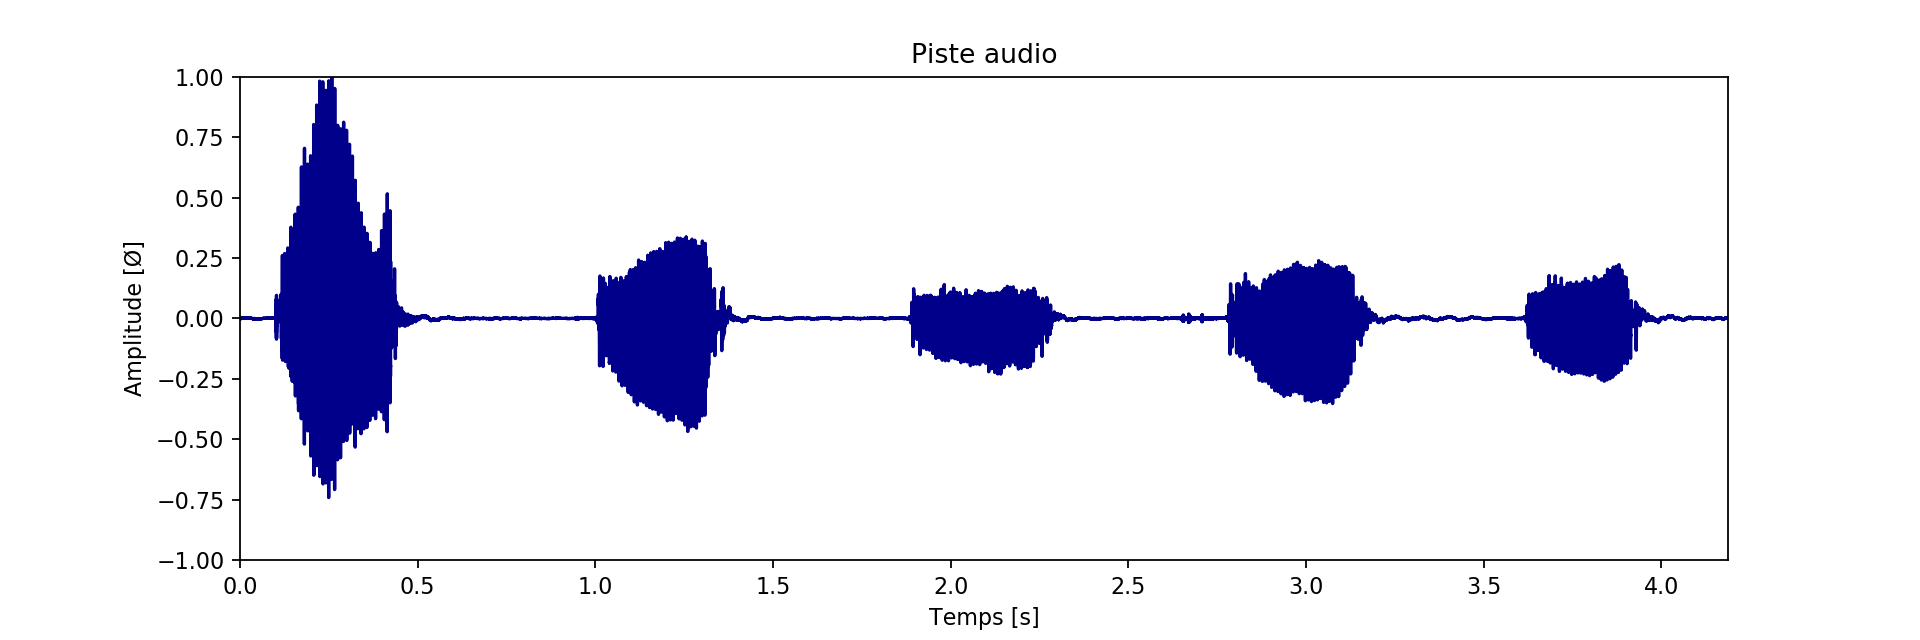

In [5]:
%run -i bin/plot_specamp.py
plot_specamp(y/max(abs(y)), t)

### Spectrogramme

Il représente la densité spectrale de puissance (par nuances de couleurs) par fréquence (en ordonnée) selon le temps (en abscisse). Les couleurs chaudes indiquent une forte énergie tandis que les couleurs froides en montrent l'absence.

Il est affiché par la fonction [**plot_specgram(y, t, fs)**](https://github.com/lowlighter/sound/blob/master/bin/plot_specgram.py).

<IPython.core.display.Javascript object>


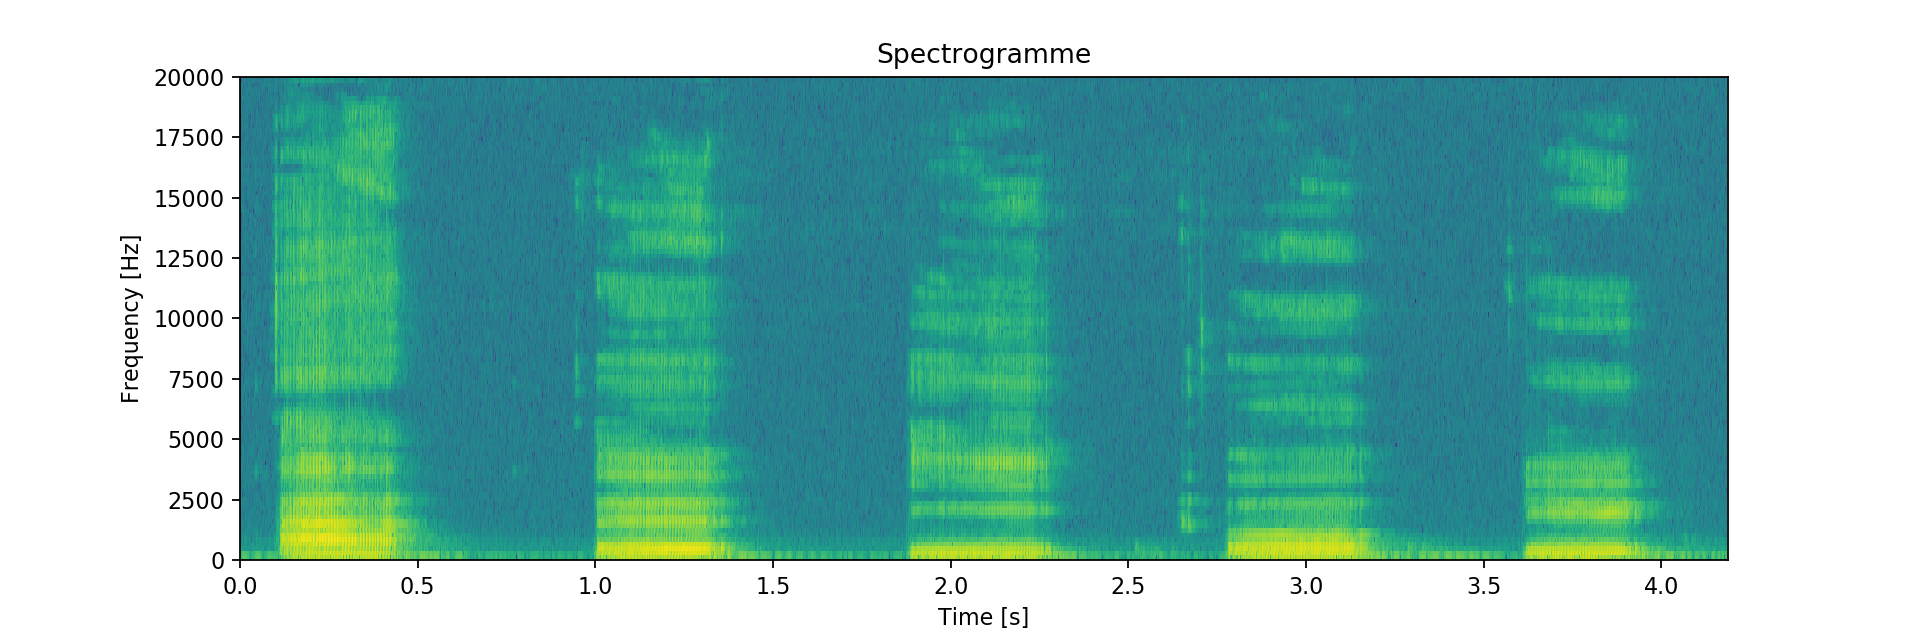

In [6]:
%run -i bin/plot_specgram.py
plot_specgram(y, t, fs)

# Banque de filtres

Ci-dessous se trouvent les paramètres de la banque de filtres :
* **fmin** : Fréquence centrale minimum
* **fmax** : Fréquence centrale maximum
* **nb_filters** : Nombre de filtres
* **n** : Ordre des filtres
* **q** : Facteur qualité

Ainsi que les paramètres de génération des spectrogrammes :
* **time_res** : Résolution temporelle (en secondes)
* **amp_res** : Résolution d'amplitude (nombre de bits pour stocker l'amplitude de l'énergie)

In [7]:
# Fréquence centrale minimale
fmin = 300
# Fréquence centrale maximale
fmax = 3000
# Nombre de filtres
nb_filters = 16

# Ordre des filtres
n = 3
# Facteur de qualité
q = 3

# Résolution temporelle des spectrogrammes
time_res = 0.1
# Nombre de bits à utiliser pour pour stocker l'amplitude de l'énergie
amp_res = 4

### Génération de la banque de filtres
Etape intermédiaire qui consiste à générer les différents filtres de la banque en fonction des paramètres ci-dessus.

La banque est générée à l'aide de la fonction [**gen_filters(q, n, fs, nb_filters=12, fmin=20, fmax=20000, fcs=False, debug=False)**](https://github.com/lowlighter/sound/blob/master/bin/gen_filters.py) qui effectue plusieurs appels à la fonction [**bandpass(fc, q, n, fs, debug=False)**](https://github.com/lowlighter/sound/blob/master/bin/bandpass.py).

Il est également possible de générer une liste de filtres avec des fréquences centrales personnalisées de cette façon : **gen_filters(q, n, fs, fcs=[fc1, fc2, ..., fc3], debug=False)**.

In [8]:
%run -i bin/bandpass.py
%run -i bin/gen_filters.py
filters, filters_fq = gen_filters(q, n, fs, nb_filters=16, fmin=fmin, fmax=fmax, debug=True)

Fc :  300Hz ( 250Hz -  350Hz)
Fc :  349Hz ( 291Hz -  408Hz)
Fc :  407Hz ( 339Hz -  475Hz)
Fc :  475Hz ( 396Hz -  554Hz)
Fc :  554Hz ( 461Hz -  646Hz)
Fc :  646Hz ( 538Hz -  754Hz)
Fc :  753Hz ( 627Hz -  879Hz)
Fc :  878Hz ( 732Hz - 1025Hz)
Fc : 1024Hz ( 853Hz - 1195Hz)
Fc : 1194Hz ( 995Hz - 1393Hz)
Fc : 1392Hz (1160Hz - 1624Hz)
Fc : 1623Hz (1352Hz - 1894Hz)
Fc : 1892Hz (1577Hz - 2208Hz)
Fc : 2206Hz (1839Hz - 2574Hz)
Fc : 2573Hz (2144Hz - 3001Hz)
Fc : 3000Hz (2500Hz - 3500Hz)


### Réponse fréquentielle de la banque de filtres

Le graphique logarithmique ci-dessous affiche les réponses fréquentielle de chaque filtre de la banque sur la plage des sons audibles par l'oreille humaine (20Hz à 20kHz).

Il est affiché par la fonction [**plot_freqz(filters)**](https://github.com/lowlighter/sound/blob/master/bin/plot_freqz.py).

<IPython.core.display.Javascript object>


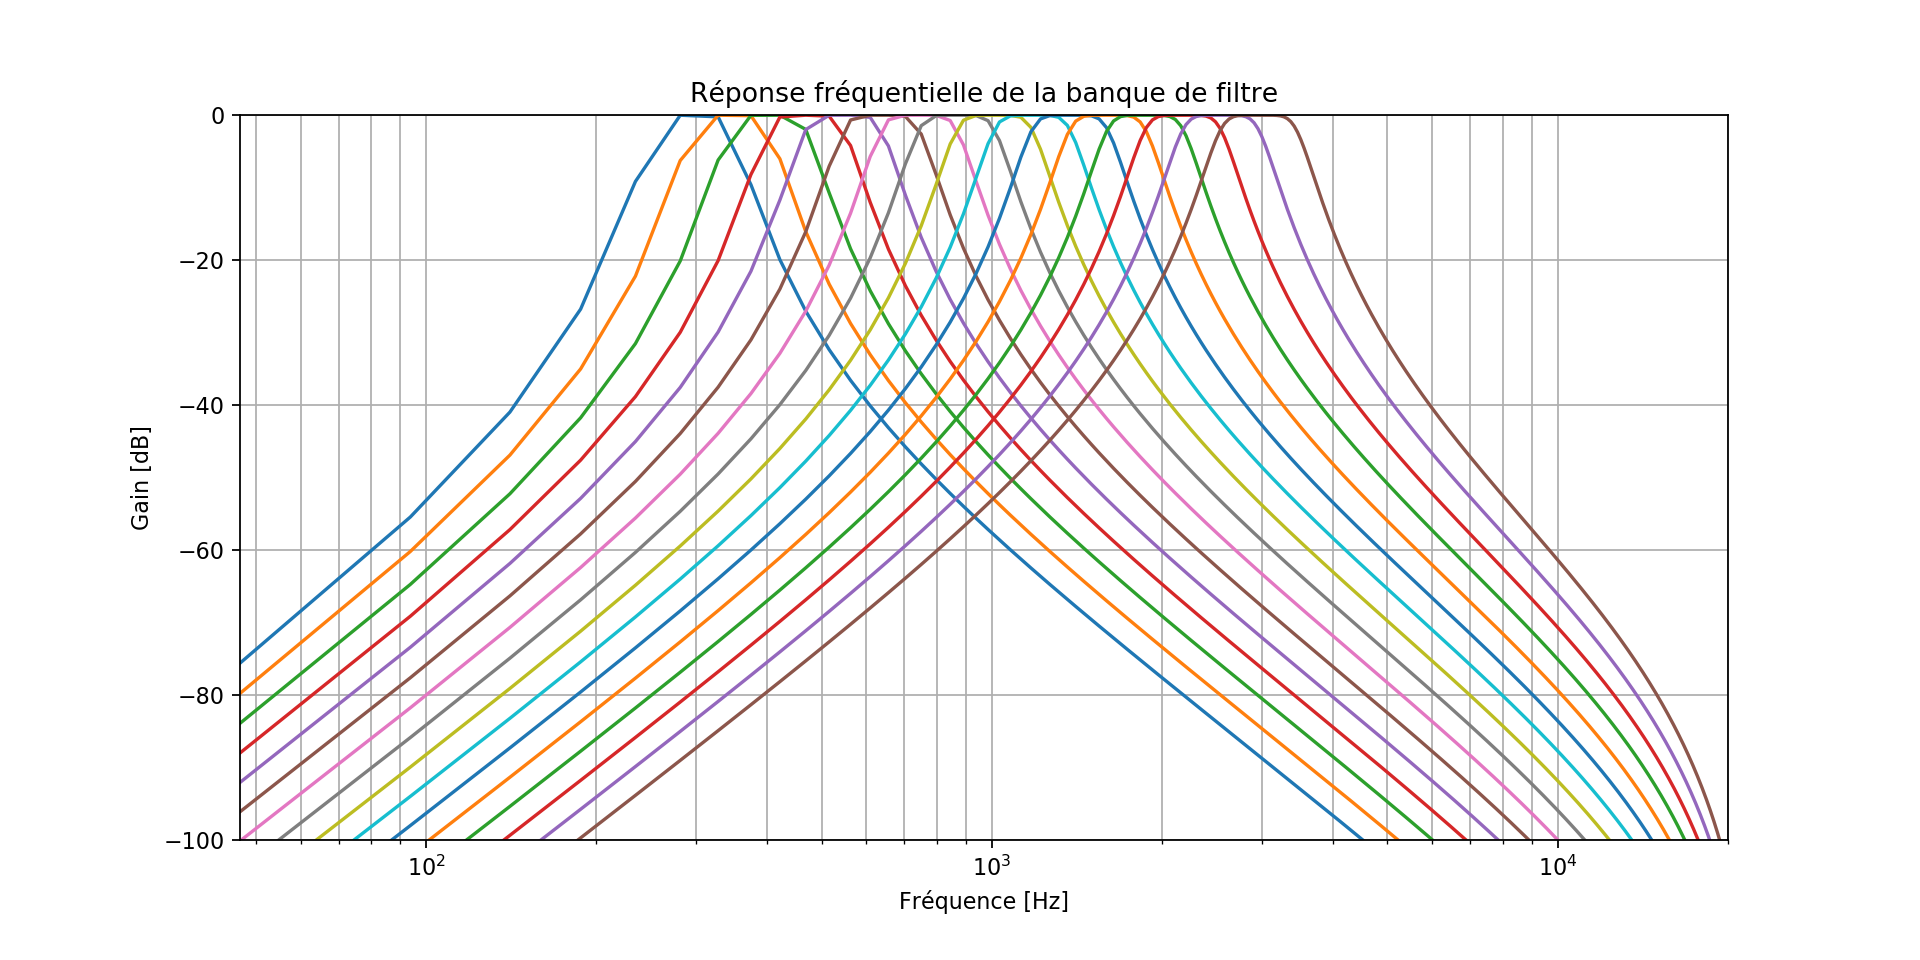

bin/plot_freqz.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx((fs/(2*np.pi))*w, 20 * np.log10(abs(h)));


In [9]:
%run -i bin/plot_freqz.py
plot_freqz(filters)

### Application de la banque de filtres

Une étape intermédiaire qui consiste à appliquer les différents filtres sur le signal d'entrée.

Les signaux après filtrages sont générés par la fonction [**gen_filtered(y, fs, filters)**](https://github.com/lowlighter/sound/blob/master/bin/gen_filtered.py) et l'affichage des signaux filtrés est réalisé par [**plot_filtered(y, t, filtered, filters_fq, nsub=4)**](https://github.com/lowlighter/sound/blob/master/bin/plot_filtered.py).

Le bleu marine représente le signal filtré et le bleu aquatique le signal d'origine.

<IPython.core.display.Javascript object>


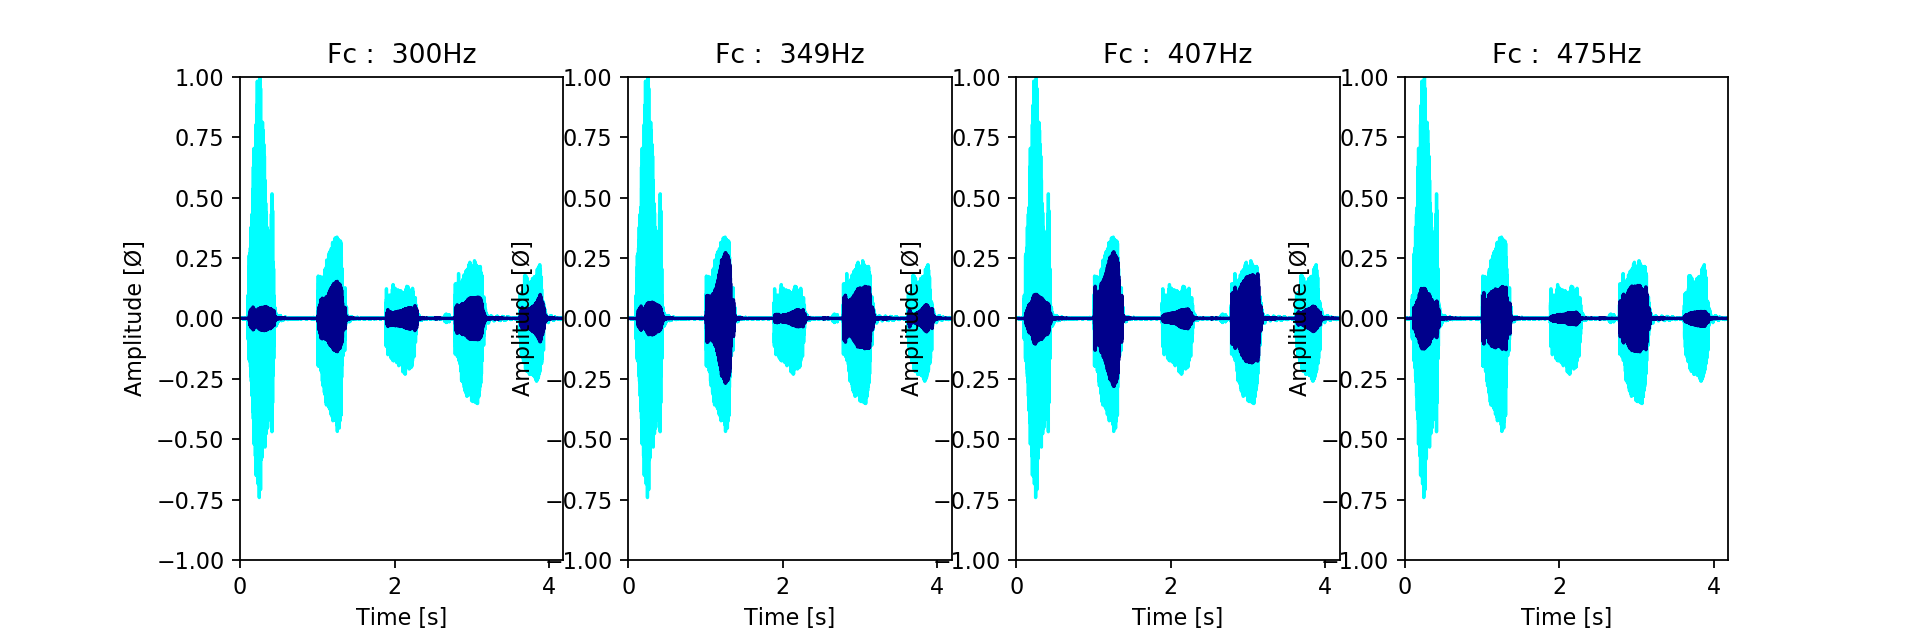

<IPython.core.display.Javascript object>


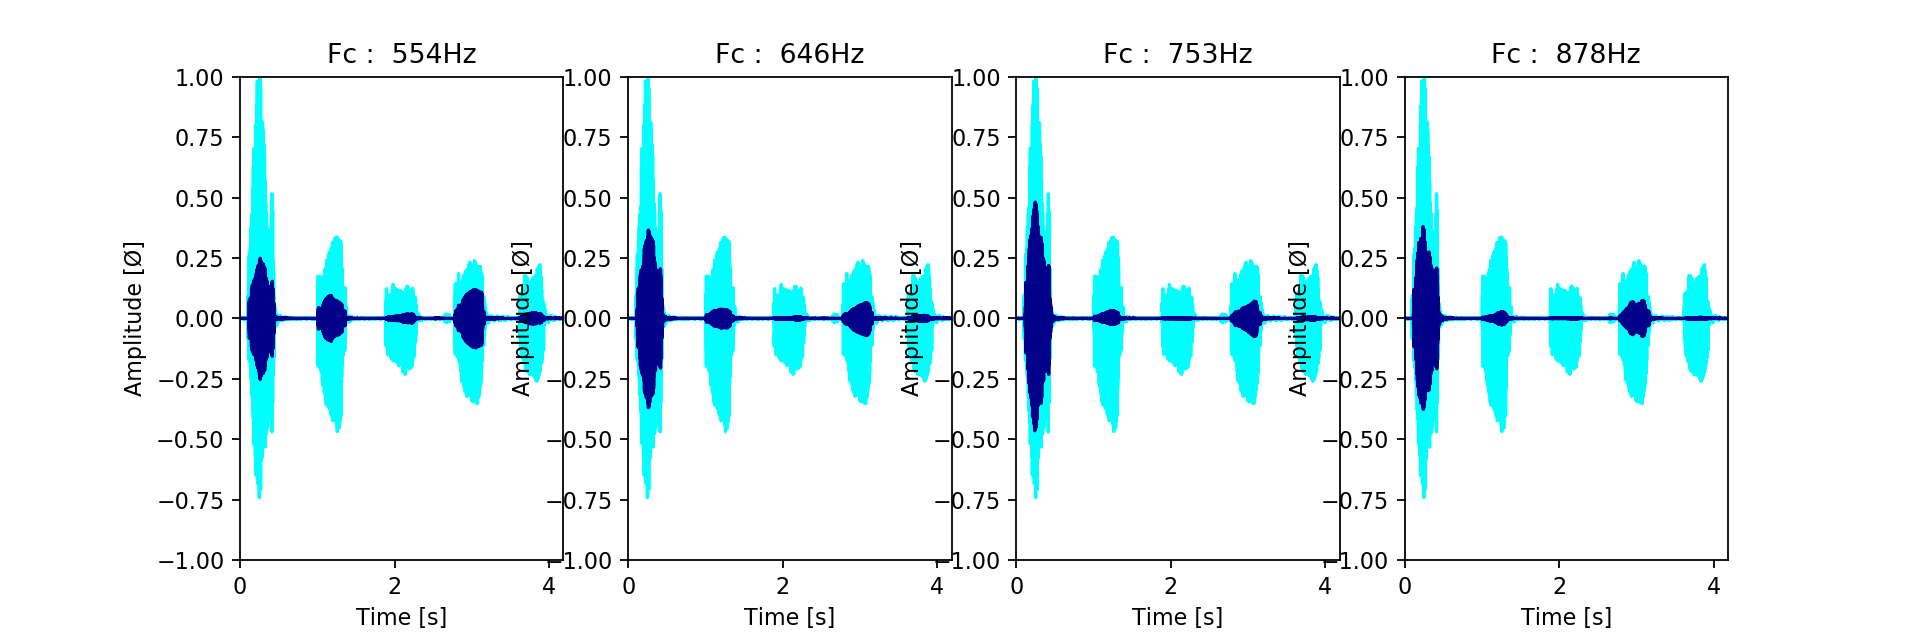

<IPython.core.display.Javascript object>


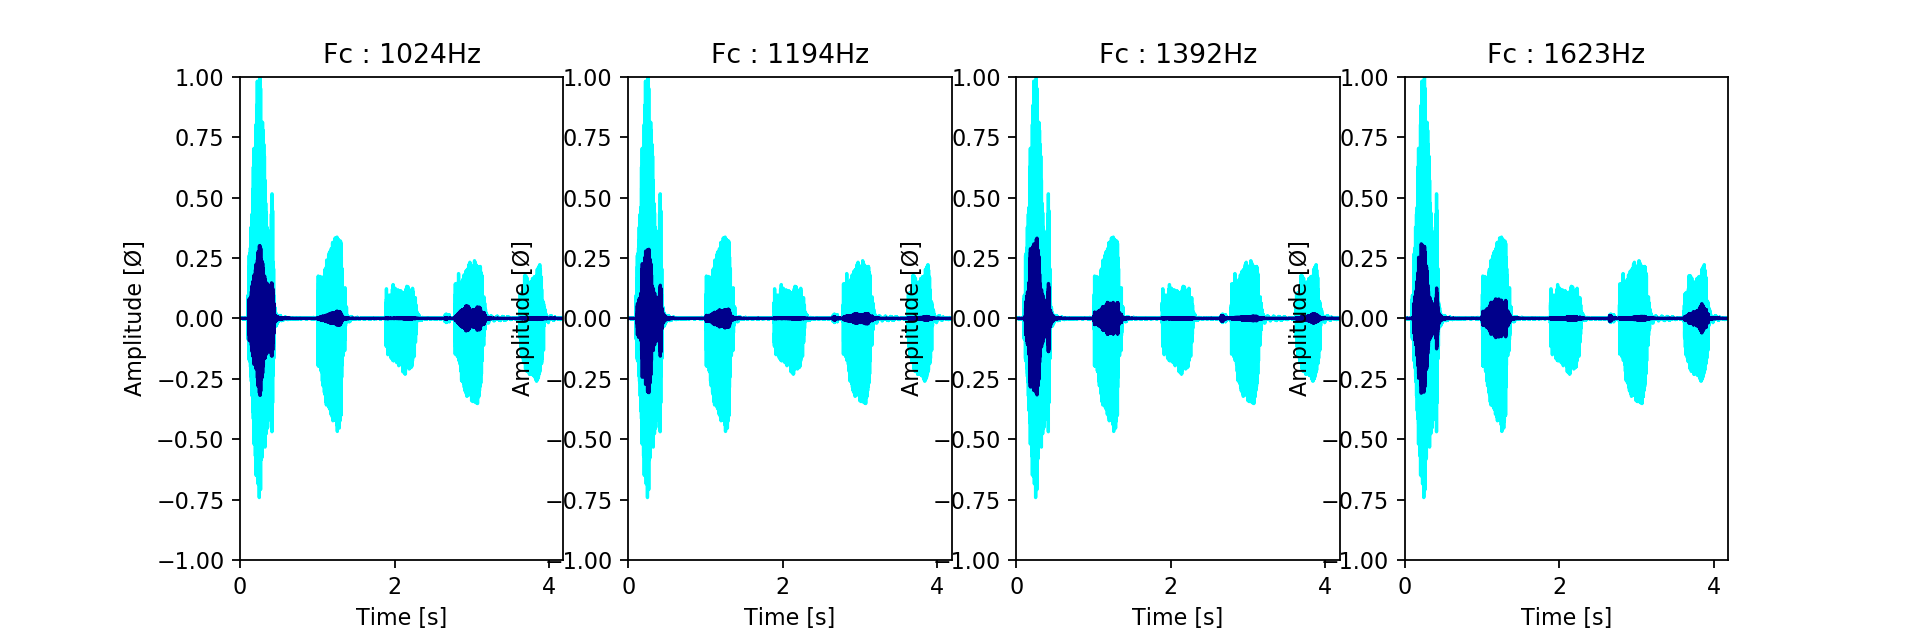

<IPython.core.display.Javascript object>


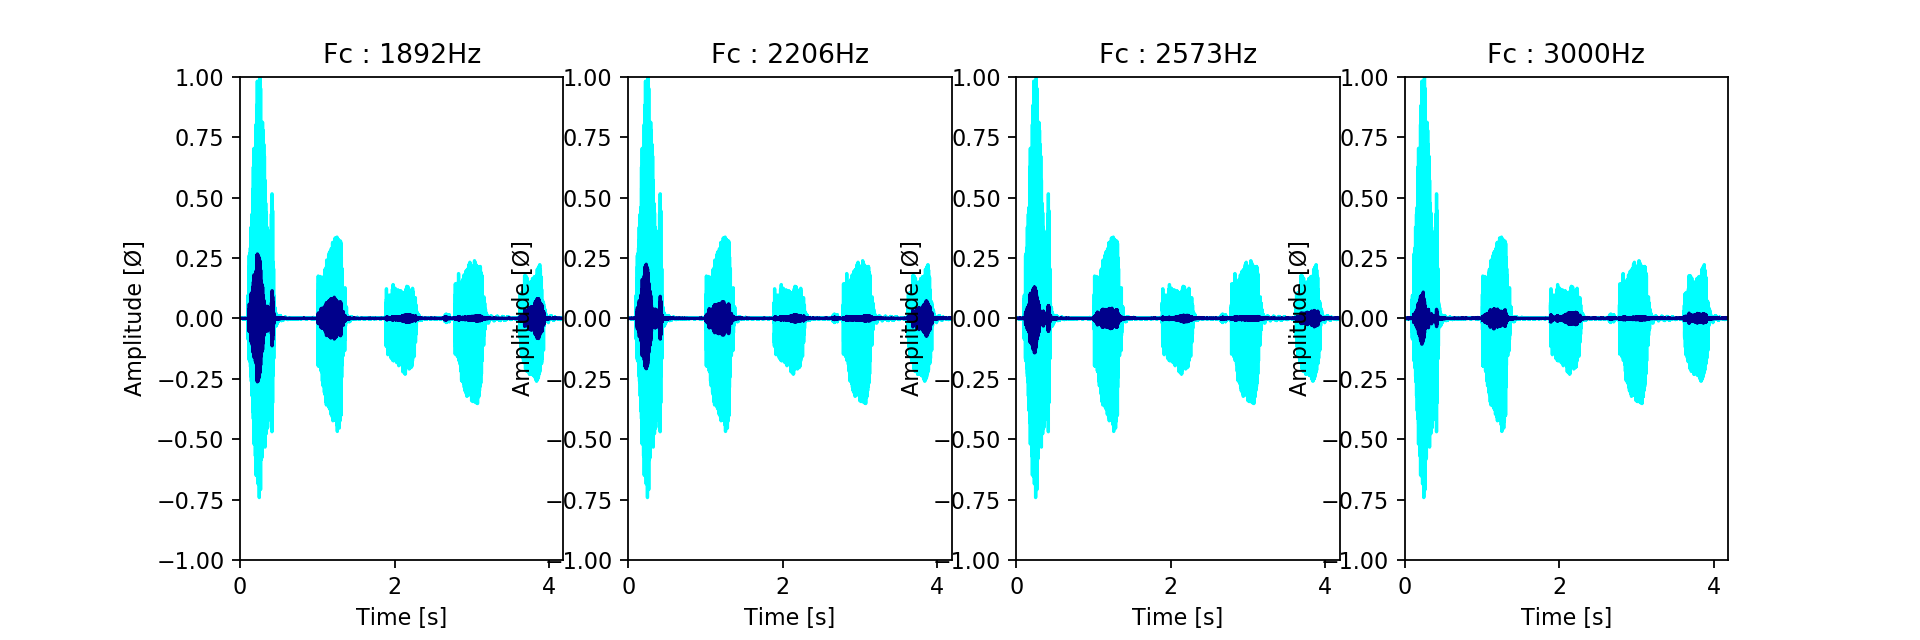

In [10]:
%run -i bin/gen_filtered.py
%run -i bin/plot_filtered.py
filtered = gen_filtered(y, fs, filters)
plot_filtered(y, t, filtered, filters_fq)

# Etude de l'énergie d'un signal en sortie de la banque
Cette partie permet de définir les fonctions qui permettent de calculer l'énergie d'un signal en sortie de la banque.

La fonction [**energies(signal, fs, dt, bits=False)**](https://github.com/lowlighter/sound/blob/master/bin/energies.py) permet de calculer l'énergie contenue dans un signal segmenté par une certaine résolution temporelle **dt**. Elle effectue de multiples appels à la fonction [**energy(signal, fs, start=0, end=False)**](https://github.com/lowlighter/sound/blob/master/bin/energy.py).

Il est possible d'afficher ces résulats en appelant directement la fonction [**plot_energies(signal, fs, dt, bits)**](https://github.com/lowlighter/sound/blob/master/bin/plot_energies.py).

Attention à ne pas utiliser un pas **dt** qui ne pourrait pas être satisfait par la fréquence d'échantillonnage **fs** !

<IPython.core.display.Javascript object>


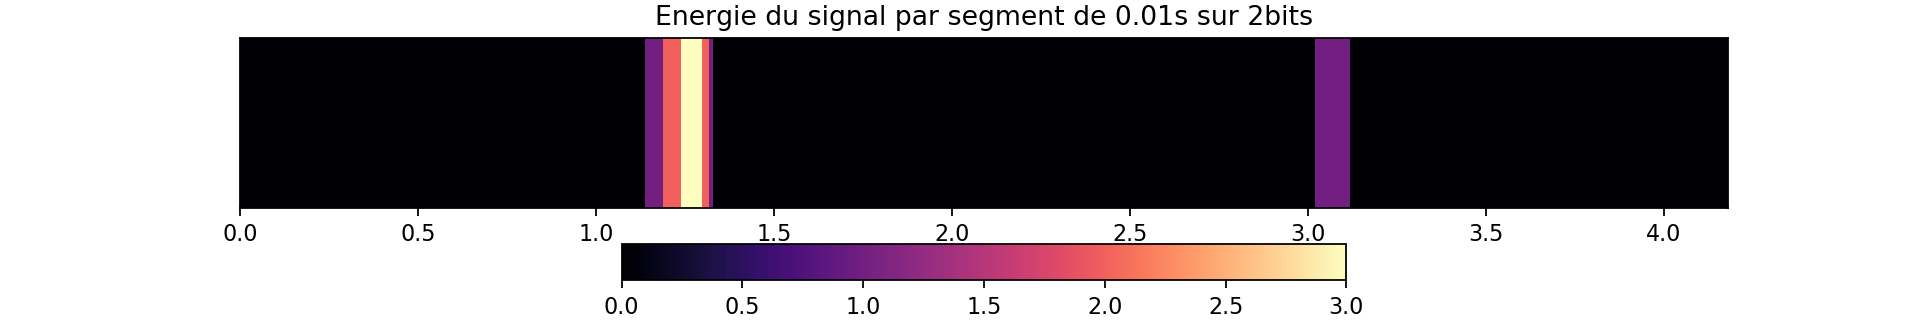

In [11]:
%run -i bin/energy.py
%run -i bin/energies.py
%run -i bin/plot_energies.py
plot_energies(filtered[1], fs, 0.01, bits=2)


# Etude de l'énergie des signaux en sortie de la banque
Cette partie affiche le signal audio en sortie, le spectrogramme associé ainsi que les états après chaque application respective des filtres de la banque.

Les données du spectrogramme sont calculés par la fonction [**gen_data(filtered, fs, time_res, amp_res, filters_fq)**](https://github.com/lowlighter/sound/blob/master/bin/gen_data.py) puis affichées par la fonction [**plot_data(y, t, rsegs, rfreqs, rseqs, ax=None)**](https://github.com/lowlighter/sound/blob/master/bin/plot_data.py).

<IPython.core.display.Javascript object>


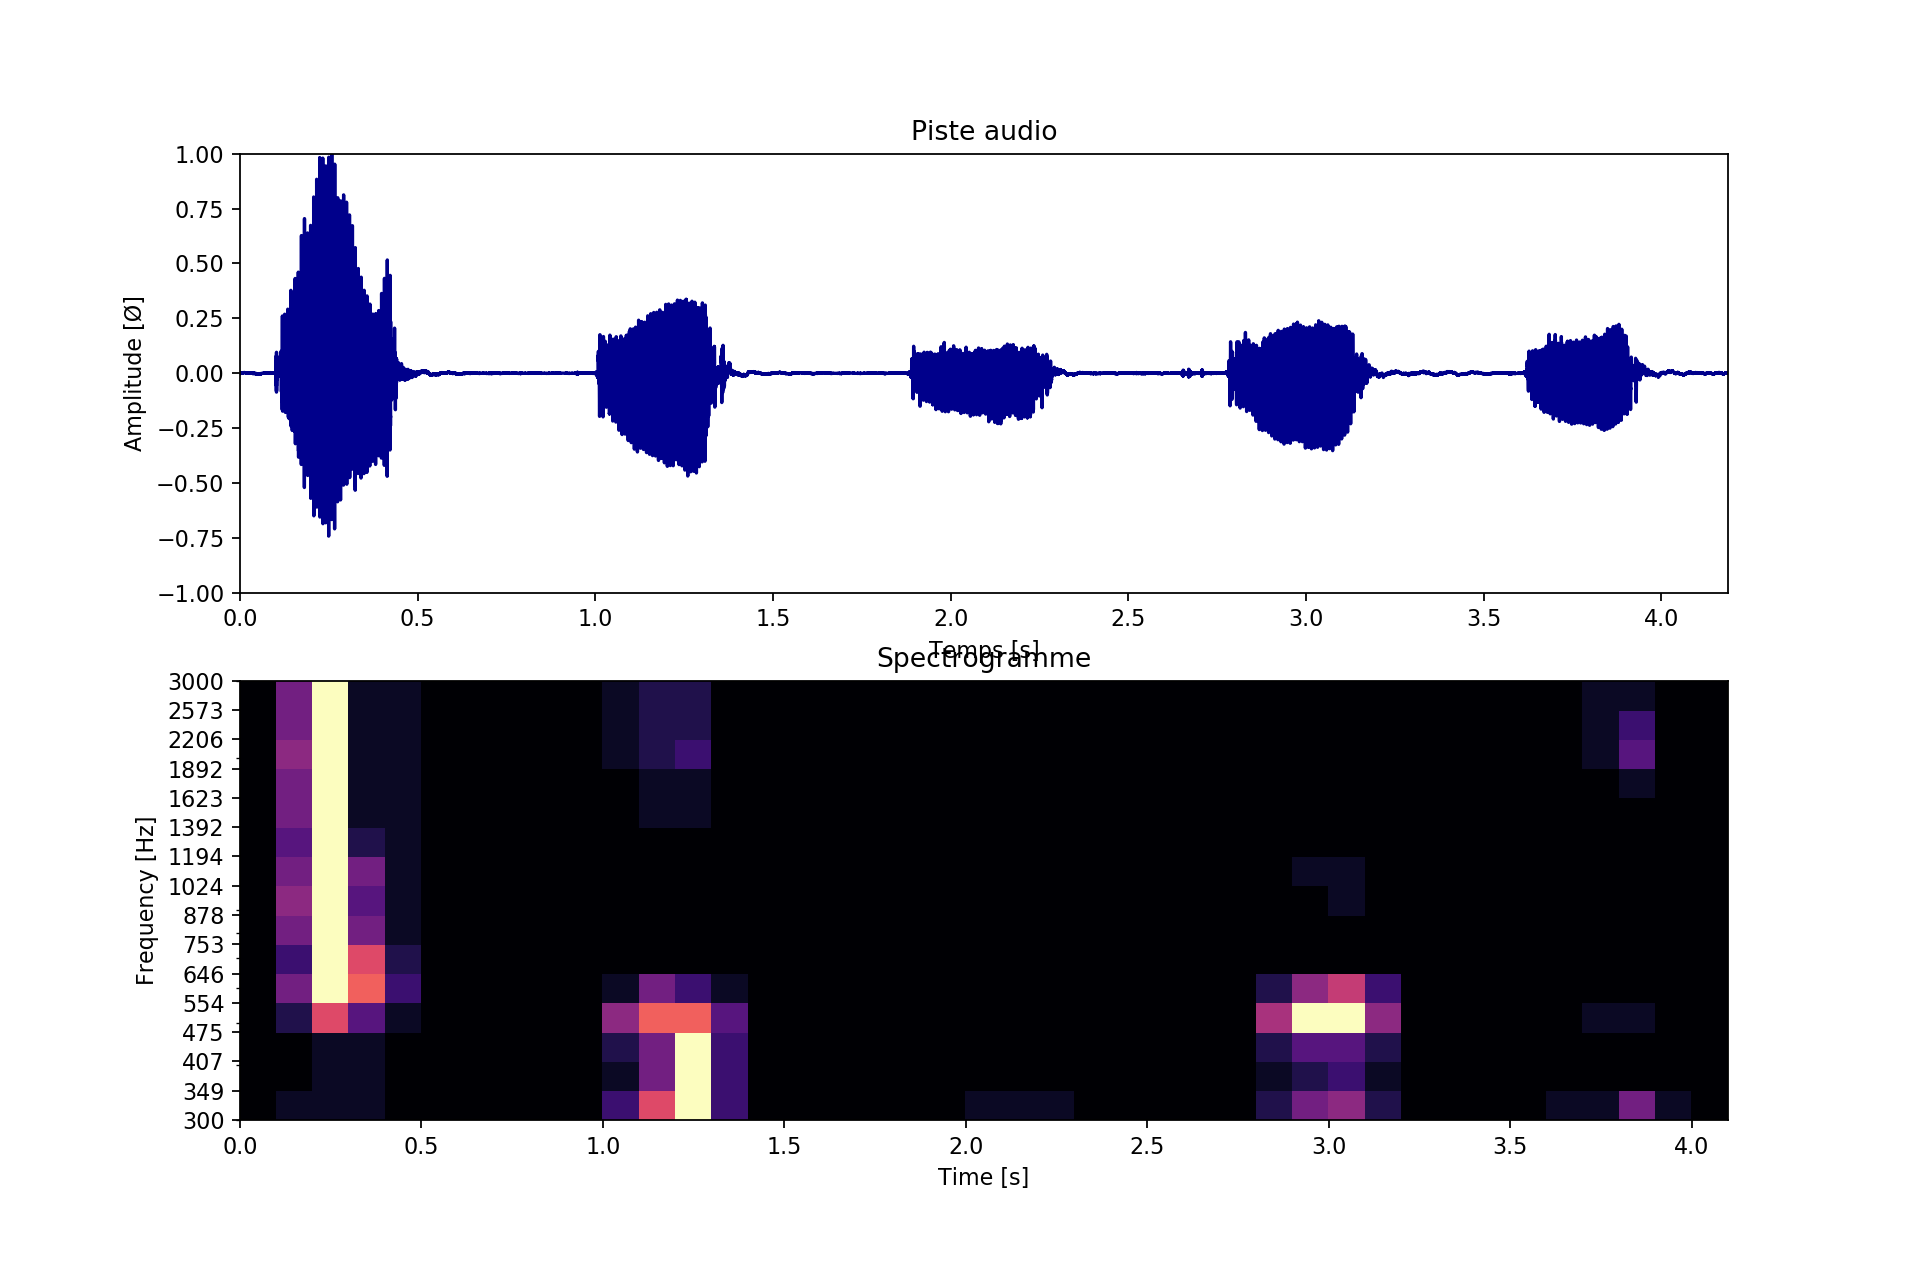

In [12]:
%run -i bin/gen_data.py
%run -i bin/plot_datagram.py
%run -i bin/plot_data.py
rsegs, rfreqs, rseqs = gen_data(filtered, fs, time_res, amp_res, filters_fq)
plot_data(y, t, rsegs, rfreqs, rseqs)

### Etude des états

Afin de faciliter le traitement des données, il est possible de lire la valeur d'un retournée par l'état d'un filtre à un instant *t* donnée en utilisant la fonction [**state_at(filter_no, s, rsegs, rseqs, debug=False)**](https://github.com/lowlighter/sound/blob/master/bin/state_at.py).

In [13]:
%run -i bin/state_at.py
print(state_at(12, 0.18, rsegs, rseqs, debug=True))

Valeur numérique du filtre n°12 pour t=0.2s
15.0


# Récapitulatif

Il est possible d'exécuter toutes les fonctions ci-dessus avec la fonction : 

[**compute(file, fs=0, time_res=0, amp_res=0, fmin=0, fmax=0, fcs=False, nb_filters=0, q=0, n=0, filters=[], filters_fq=[], ax=None, spec_only=False, spec_xlim=False)**](https://github.com/lowlighter/sound/blob/master/bin/compute.py)

Afin de réduire les temps de calculs, il est possible d'exécuter cette fonction de différentes façons.

### **Sélection de la source**
* **file** : Source du fichier à ouvrir (string)

OU 

* **file** : Signal d'entrée (liste d'amplitudes)
* **fs** : Fréquence d'échantillonage

### **Sélection de la banque de filtres**
* **filters** : Banque de filtre déjà généré (permet d'éviter de les regénérer à chaque fois)
* **filters_fq** : Données caractéristiques des filtres déjà générés

OU

* **fmin** : Fréquence minimum
* **fmax** : Fréquence maximum
* **nb_filters** : Nombre de filtres
* **q** : Facteur de qualité
* **n** : Ordre du filtre

OU

* **fcs** : Liste de fréquences centrales personnalisées
* **q** : Facteur de qualité
* **n** : Ordre du filtre

### **Configuration du spectrogramme**
* **time_res** : Résolution temporelle
* **amp_res** : Résolution en amplitude
* **spec_only** : Afficher uniquement le spectrogramme (indiquer le titre)  
* **spec_xlim** : Limite en abscisse du spectrogramme

### **Utilisation d'une figure déjà existante**
* **f** : Figure contenant ax (laisser vide si le paramètre ax n'est pas spécifié)
* **ax** : Surface de dessin existante (laisser vide pour créer une nouvelle figure)

Par exemple, pour charger un fichier, générer une banque de filtre et afficher le spectre d'amplitude ainsi que le spectrogramme, il suffit d'écrire :

<IPython.core.display.Javascript object>


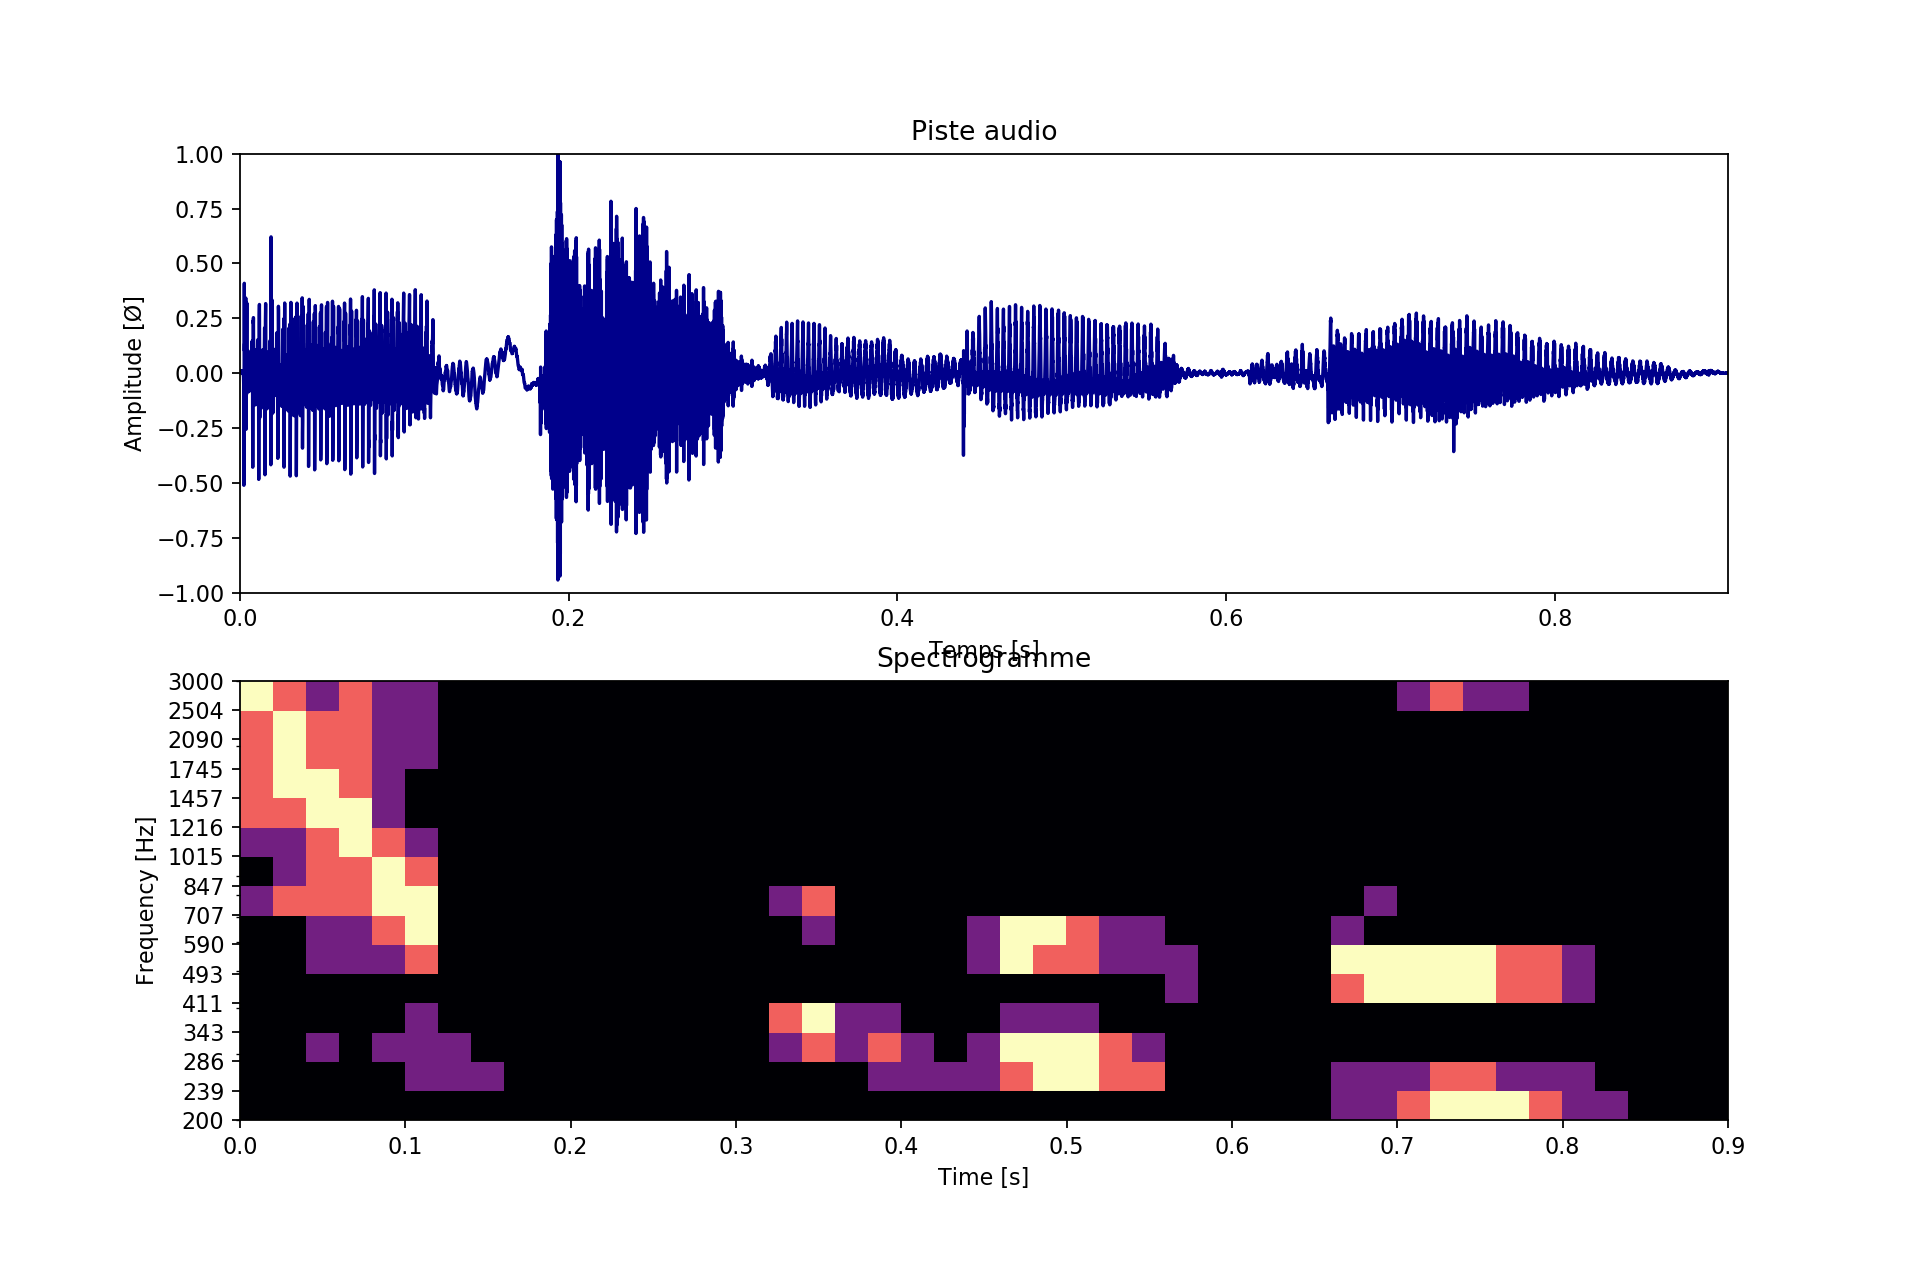

In [14]:
%run -i bin/compute.py
compute(
    file="src/Words/voice_F1_absolutely_2.wav", 
    fmin=200, 
    fmax=3000, 
    nb_filters=16, 
    q=3, 
    n=3, 
    time_res=0.02, 
    amp_res=2
);

# Comparaison de plusieurs fichiers audios

La fonction [**compare(word, persons, time_res=0, amp_res=0, fmin=0, fmax=0, fcs=False, nb_filters=0, q=0, n=0, filters=\[\], filters_fq=\[\], compare_format="")**](https://github.com/lowlighter/sound/blob/master/bin/compare.py) est un raccourci de la fonction **compute** qui permet de charger plusieurs fichiers pour pouvoir les comparer.

Par exemple, l'appel à la fonction **compare** permet de visualiser le spectrogramme du mot **together** prononcé par 4 personnes différentes.

C:\ProgramUser\Anaconda\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


<IPython.core.display.Javascript object>


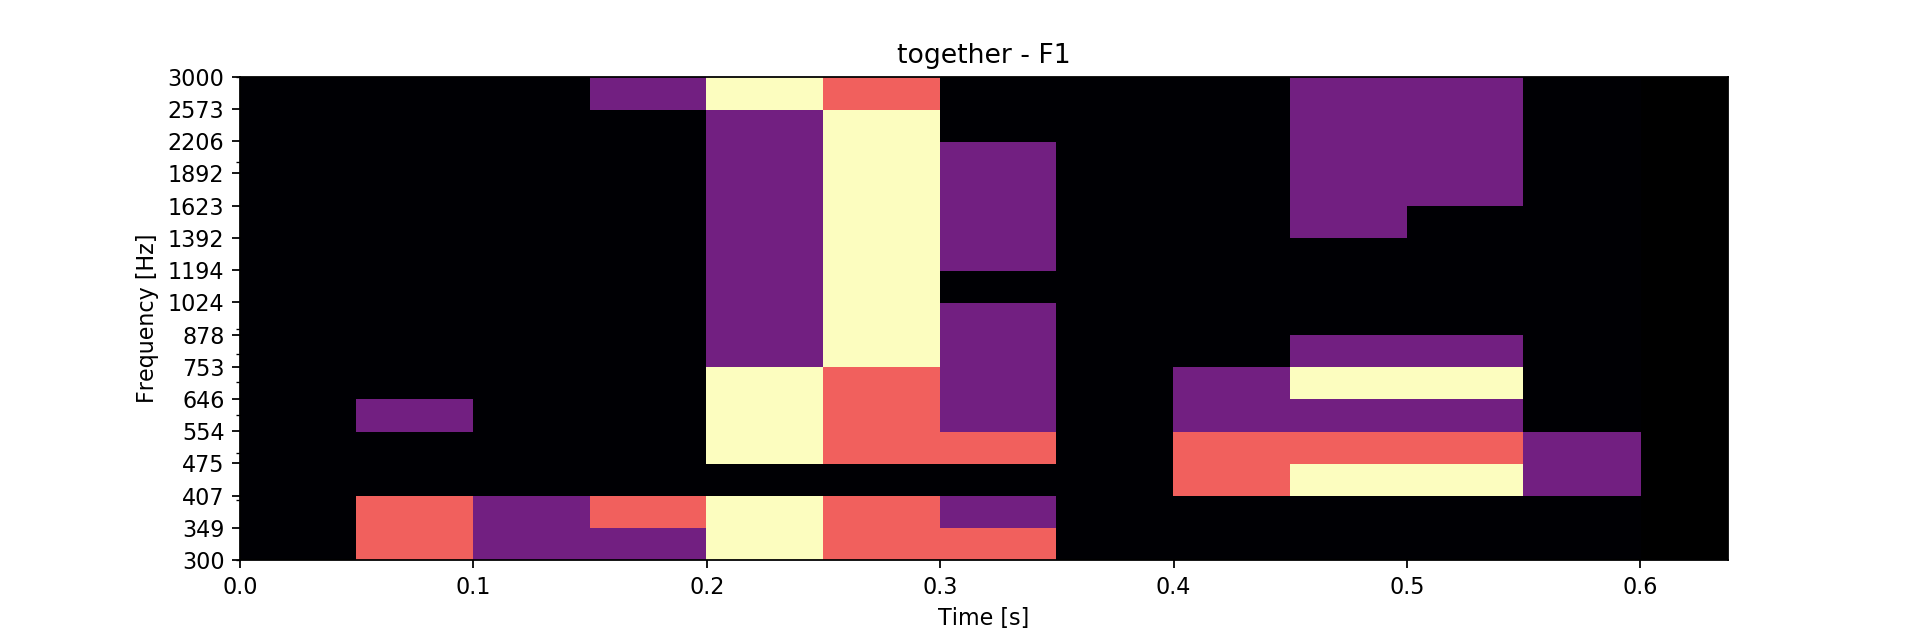

<IPython.core.display.Javascript object>


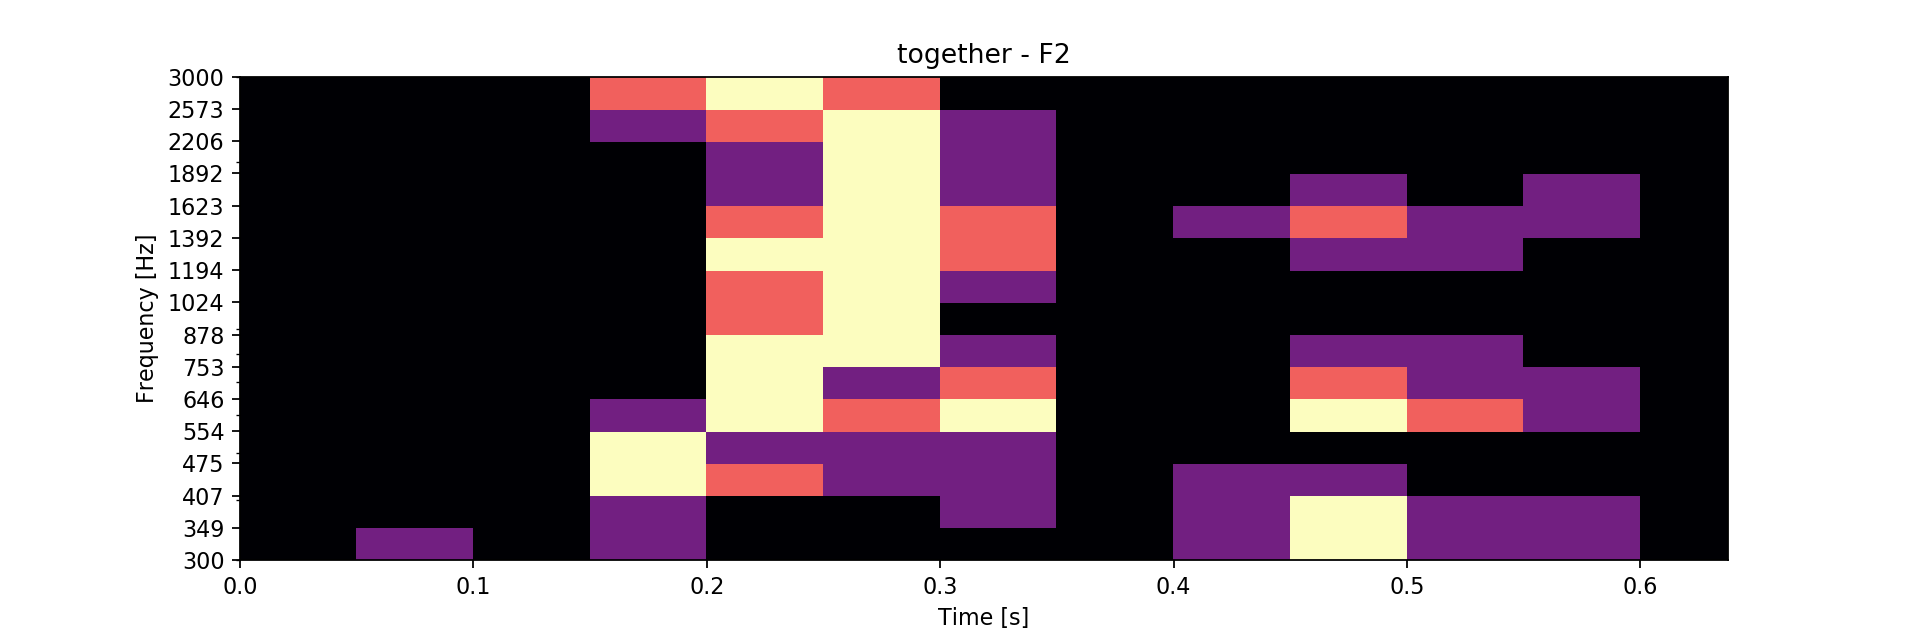

<IPython.core.display.Javascript object>


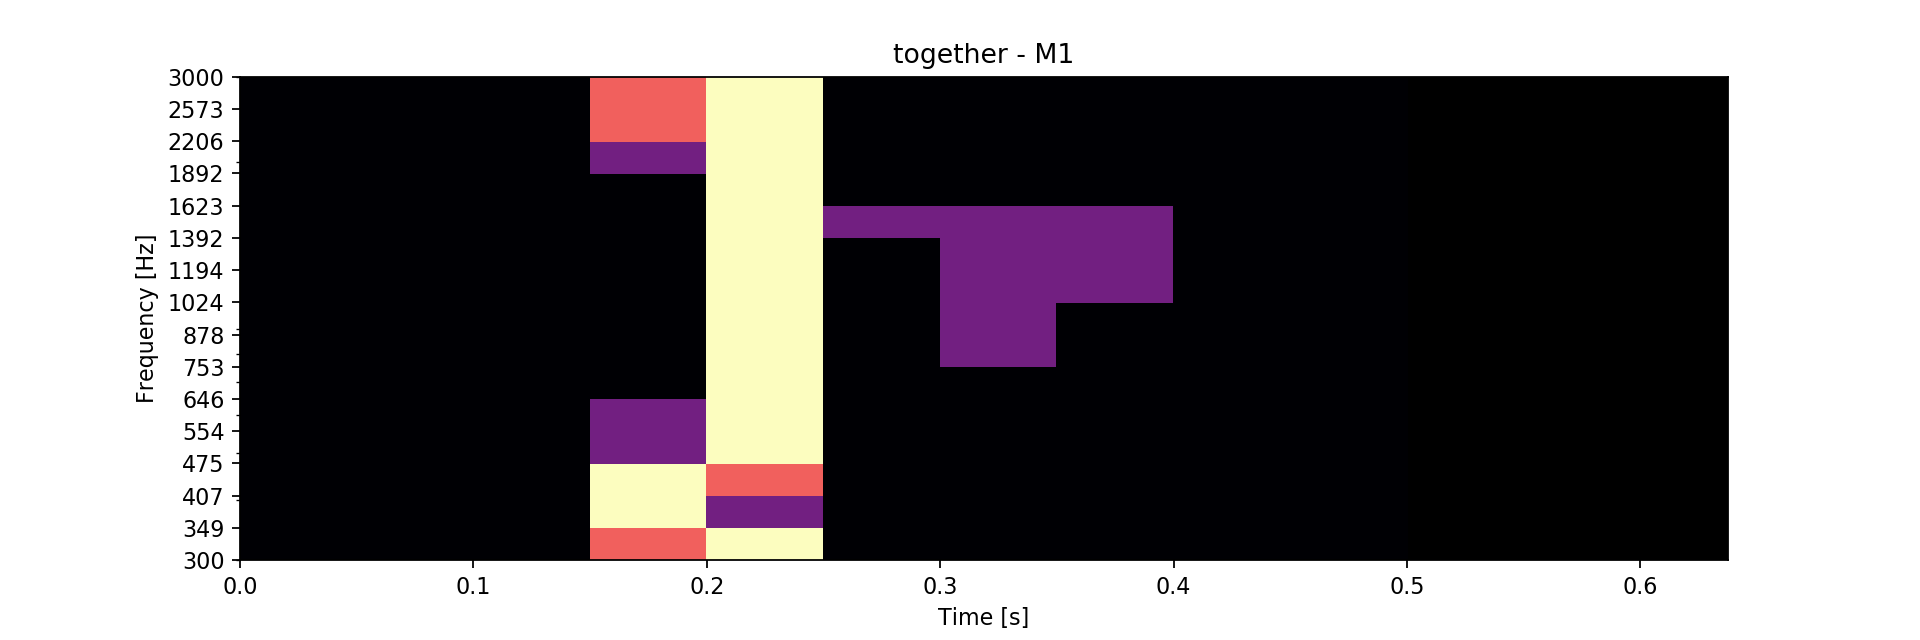

<IPython.core.display.Javascript object>


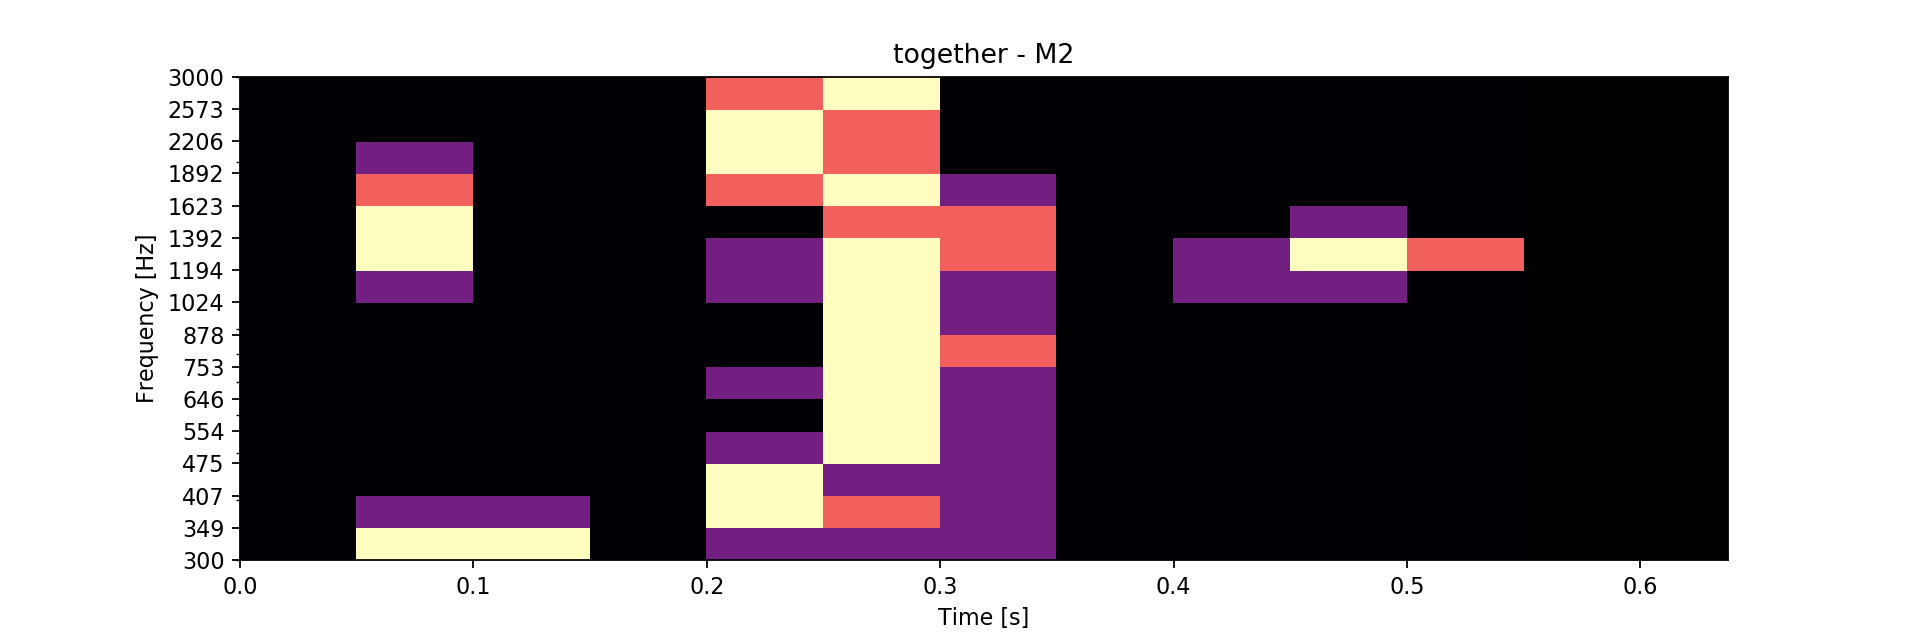

In [15]:
%run -i bin/compare.py
compare(
    compare_format = "src/Words/voice_{person}_{word}_2.wav",
    words=["together"],
    persons=["F1", "F2", "M1", "M2"],
    fmin=300, 
    fmax=3000, 
    nb_filters=16, 
    q=3, 
    n=3, 
    time_res=0.05, 
    amp_res=2
)

# Traitement à la volée

Si **[pyaudio](https://people.csail.mit.edu/hubert/pyaudio/)** est installé sur votre machine, il est possible d'enregistrer des sons depuis votre microphone et de les traiter au fur et à mesure (avec un léger décalage).

Pour cela, assurer vous de configurer correctement les deux variables suivantes, ce qui permettra d'inclure de nouvelles bibliothèques requises pour faire fonctionner la suite de ce programme.

In [16]:
# Chemin vers les bibliothèques Python
lib_path = "C:\Program Files\Python36\Lib\site-packages"
# Chemin où stocker le fichier audio généré
src_out = "src/output.wav"

In [17]:
%run -i bin/imports_pyaudio.py

Vous pouvez également configurer plus en détail les différents paramètres pour l'enregistrement, même s'il est conseillé de les laisser tel quel.

In [18]:
# Durée de l'enregistrement
duration = 0.25

# Format d'enregistrement
dformat = pyaudio.paInt16
# Nombre de canaux
channels = 1
# Fréquence d'échantillonage
fs = 48000
# Taille des blocs enregistrés
chunk_size = 1024

L'enregistrement est réalisé par la fonction [**live_record()**](https://github.com/lowlighter/sound/blob/master/bin/live_record.py).

Le code suivant permet de commencer un nouvel enregistrement et de traiter en temps réel les données.

Il faut **interrompre** le kernel afin de pouvoir arrêter l'exécution de cette cellule et pouvoir en utiliser d'autres :
![Interruption](src/stop.png)

In [19]:
%run -i bin/live_record.py
try:
    # Paramètrage de l'enregistrement live
    filters, filters_fq = gen_filters(fmin=300, fmax=3000, nb_filters=16, q=3, n=3, fs=fs)
    live_record(time_res=0.1, amp_res=2, filters_fq=filters_fq, filters=filters)

# Masque l'erreur en cas d'interruption du Kernel
except KeyboardInterrupt:
    clear_output() ; print("Terminé !") ; quit

Terminé !
